In [27]:
import networkx as nx
import fast_model_improved as fmi
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy

In [28]:
from pyexpat import model

def create_network(network_type='random', num_nodes=1000, num_edges=0, prob=0.01):
    if network_type == 'random':
        G = nx.gnm_random_graph(num_nodes, num_edges)
    elif network_type == 'scale_free':
        G = nx.scale_free_graph(num_nodes)
    elif network_type == 'erdos_renyi':
        G = nx.erdos_renyi_graph(num_nodes, prob)
    elif network_type == 'preferential_attachment':
        G = nx.barabasi_albert_graph(num_nodes, 2)
    elif network_type == 'small_world':
        G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.1)
    else:
        raise ValueError("Unsupported network type")
    return G

def choose_influencers(model, num_influencers, method='random'):
    if method == 'random':
        return model.random_influencers(num_influencers)
    elif method == 'hill_climbing':
        return model.greedy_hill_climbing(num_influencers, steps=10, R=10)
    else:
        raise ValueError("Unsupported method for selecting influencers")

def run_influence_cascade(graph, num_influencers, steps, selection_method='random'):

    # Initialize the model
    model = fmi.InfluenceDeinfluenceModel(graph, selection_method)
    
    # Choose influencers
    influencers = choose_influencers(model, num_influencers, method=selection_method)
    model.set_influencers(influencers)
    model.selected_influencers = influencers
    
    # Run the cascade
    model.run_cascade(steps)
    
    # Return the updated graph and model
    return model

def run_simple_cascade(steps):
    model.set_influencers(model.selected_influencers)
    model.run_cascade(steps)
    return model


In [29]:
# Define the combined count function
def count_deinfluenced(model, deinfluencers, num_runs):
    total_deinfluenced = 0
    total_influenced = 0
    total_transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
    
    # Create a deep copy of the model to ensure initial influencers remain the same
    initial_model = copy.deepcopy(model)
    
    for _ in range(num_runs):
        # Reset the model to the initial state with the same influencers
        model = copy.deepcopy(initial_model)
        model.reset_transition_counts()
        model.set_deinfluencers(deinfluencers)
        model.run_cascade_until_stable()
        
        total_deinfluenced += model.evaluate_deinfluence()
        total_influenced += model.evaluate_influence()
        
        for key in total_transition_counts:
            total_transition_counts[key] += model.transition_counts[key]
            
    return total_deinfluenced / num_runs, total_influenced / num_runs, {key: total / num_runs for key, total in total_transition_counts.items()}

In [30]:
G = create_network('preferential_attachment', 2000)
model = run_influence_cascade(G, num_influencers=50, steps=3, selection_method='random')

# Evaluate the influence and deinfluence
num_influenced = model.evaluate_influence()
num_deinfluenced = model.evaluate_deinfluence()
num_susceptible = model.evaluate_susceptible()

print(f"Number of influenced nodes: {num_influenced}")
print(f"Number of deinfluenced nodes: {num_deinfluenced}")
print(f"Number of susceptible nodes: {num_susceptible}")
print('influencer', model.selected_influencers)

# Create a deep copy of the model
model_fixed_influencers = copy.deepcopy(model)

Number of influenced nodes: 1015
Number of deinfluenced nodes: 0
Number of susceptible nodes: 985
influencer {770, 899, 1029, 1928, 1929, 1034, 1802, 141, 1040, 1936, 274, 275, 1811, 1428, 278, 532, 923, 157, 551, 680, 1575, 1704, 1965, 1456, 304, 562, 566, 695, 1335, 194, 1603, 1348, 1477, 585, 1353, 335, 82, 470, 1112, 476, 1888, 231, 999, 362, 1906, 1268, 120, 889, 1786, 892}


In [31]:
num_influenced = model.evaluate_influence()
num_deinfluenced = model.evaluate_deinfluence()
num_susceptible = model.evaluate_susceptible()

print(f"Number of influenced nodes: {num_influenced}")
print(f"Number of deinfluenced nodes: {num_deinfluenced}")
print(f"Number of susceptible nodes: {num_susceptible}")

k_deinfluencers = 5

optimized_influencers = model.selected_influencers

# Determine deinfluencers using different methods
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
random_besides_ini_influencers = model.select_deinfluencers_from_not_ini_influencers(k_deinfluencers)
random_besides_all_influencers = model.select_deinfluencers_from_not_influencers(k_deinfluencers)

print("Random deinfluencers:", random_deinfluencers)
print("Random deinfluencers besides initial influencers:", random_besides_ini_influencers)
print("Random deinfluencers besides all influencers:", random_besides_all_influencers)

# Centralities disregard the influencers
degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)

print("Degree centrality deinfluencers:", degree_centrality_ranking)
print("Closeness centrality deinfluencers:", closeness_centrality_ranking)
print("Betweenness centrality deinfluencers:", betweenness_centrality_ranking)
print("Eigenvector centrality deinfluencers:", eigenvector_centrality_ranking)
print("Pagerank centrality deinfluencers:", pagerank_centrality_ranking)
# print(f"Number of influenced nodes: {num_influenced}")
# print(f"Number of deinfluenced nodes: {num_deinfluenced}")
# print(f"Number of susceptible nodes: {num_susceptible}")

# Select deinfluencers based on initial influencers
deinfluencers_from_influencers_ini = model.select_deinfluencers_from_ini_influencers(k_deinfluencers)
ranked_deinfluencers_from_influencers_ini = model.select_deinfluencers_from_ini_influencers_degree_centrality(k_deinfluencers)

print("Deinfluencers from influencers based on initial influencers:", deinfluencers_from_influencers_ini)
print("Ranked deinfluencers from influencers based on initial influencers:", ranked_deinfluencers_from_influencers_ini)

# Select deinfluencers based on all influencers
deinfluencers_from_influencers = model.select_deinfluencers_from_influencers(k_deinfluencers)
ranked_deinfluencers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)

print("Deinfluencers from influencers based on all influencers:", deinfluencers_from_influencers)
print("Ranked deinfluencers from influencers based on all influencers:", ranked_deinfluencers_from_influencers)

# Hill climbing methods
#hill_climbing_deinfluencers = {0, 3, 5, 6, 8, 9, 239, 336, 854, 87}
hill_climbing_deinfluencers = model.greedy_hill_climbing_deinf(k_deinfluencers, steps=3, R=5)
print("Hill climbing deinfluencers:", hill_climbing_deinfluencers)

Number of influenced nodes: 1015
Number of deinfluenced nodes: 0
Number of susceptible nodes: 985
Random deinfluencers: [427, 1079, 1659, 1399, 175]
Random deinfluencers besides initial influencers: [1079, 1390, 621, 633, 268]
Random deinfluencers besides all influencers: [1408, 1498, 1577, 1432, 862]
Degree centrality deinfluencers: [2, 5, 0, 4, 47]
Closeness centrality deinfluencers: [2, 5, 0, 3, 4]
Betweenness centrality deinfluencers: [2, 5, 0, 4, 3]
Eigenvector centrality deinfluencers: [2, 5, 0, 3, 4]
Pagerank centrality deinfluencers: [2, 5, 0, 4, 47]
Deinfluencers from influencers based on initial influencers: [532, 1888, 1928, 1335, 1802]
Ranked deinfluencers from influencers based on initial influencers: [304, 141, 120, 274, 566]
Deinfluencers from influencers based on all influencers: [550, 480, 1527, 1786, 209]
Ranked deinfluencers from influencers based on all influencers: [2, 5, 0, 4, 47]
Hill climbing deinfluencers: {0, 1, 2, 3, 4}


In [32]:
# Evaluate the influence and deinfluence
num_influenced = model_fixed_influencers.evaluate_influence()
num_deinfluenced = model_fixed_influencers.evaluate_deinfluence()
num_susceptible = model_fixed_influencers.evaluate_susceptible()

print(f"Number of influenced nodes: {num_influenced}")
print(f"Number of deinfluenced nodes: {num_deinfluenced}")
print(f"Number of susceptible nodes: {num_susceptible}")
print('influencer', model.selected_influencers)


Number of influenced nodes: 1015
Number of deinfluenced nodes: 0
Number of susceptible nodes: 985
influencer {770, 899, 1029, 1928, 1929, 1034, 1802, 141, 1040, 1936, 274, 275, 1811, 1428, 278, 532, 923, 157, 551, 680, 1575, 1704, 1965, 1456, 304, 562, 566, 695, 1335, 194, 1603, 1348, 1477, 585, 1353, 335, 82, 470, 1112, 476, 1888, 231, 999, 362, 1906, 1268, 120, 889, 1786, 892}


Results for deinfluenced nodes:
Random: 1993.87 nodes deinfluenced on average
RdExIniInf: 1993.87 nodes deinfluenced on average
RdExAllInf: 1994.60 nodes deinfluenced on average
Degree: 1994.73 nodes deinfluenced on average
Closeness: 1993.73 nodes deinfluenced on average
Betweenness: 1993.93 nodes deinfluenced on average
Eigenvector: 1994.27 nodes deinfluenced on average
PageRank: 1994.60 nodes deinfluenced on average
HillClimbing: 1993.33 nodes deinfluenced on average
RdIniInf: 1991.53 nodes deinfluenced on average
RdAllInf: 1994.53 nodes deinfluenced on average
RRkIniInf: 1994.47 nodes deinfluenced on average
RRkAllInf: 1993.27 nodes deinfluenced on average

Results for influenced nodes:
Random: 6.13 nodes influenced on average
RdExIniInf: 6.00 nodes influenced on average
RdExAllInf: 5.40 nodes influenced on average
Degree: 5.00 nodes influenced on average
Closeness: 5.80 nodes influenced on average
Betweenness: 5.73 nodes influenced on average
Eigenvector: 5.27 nodes influenced on 

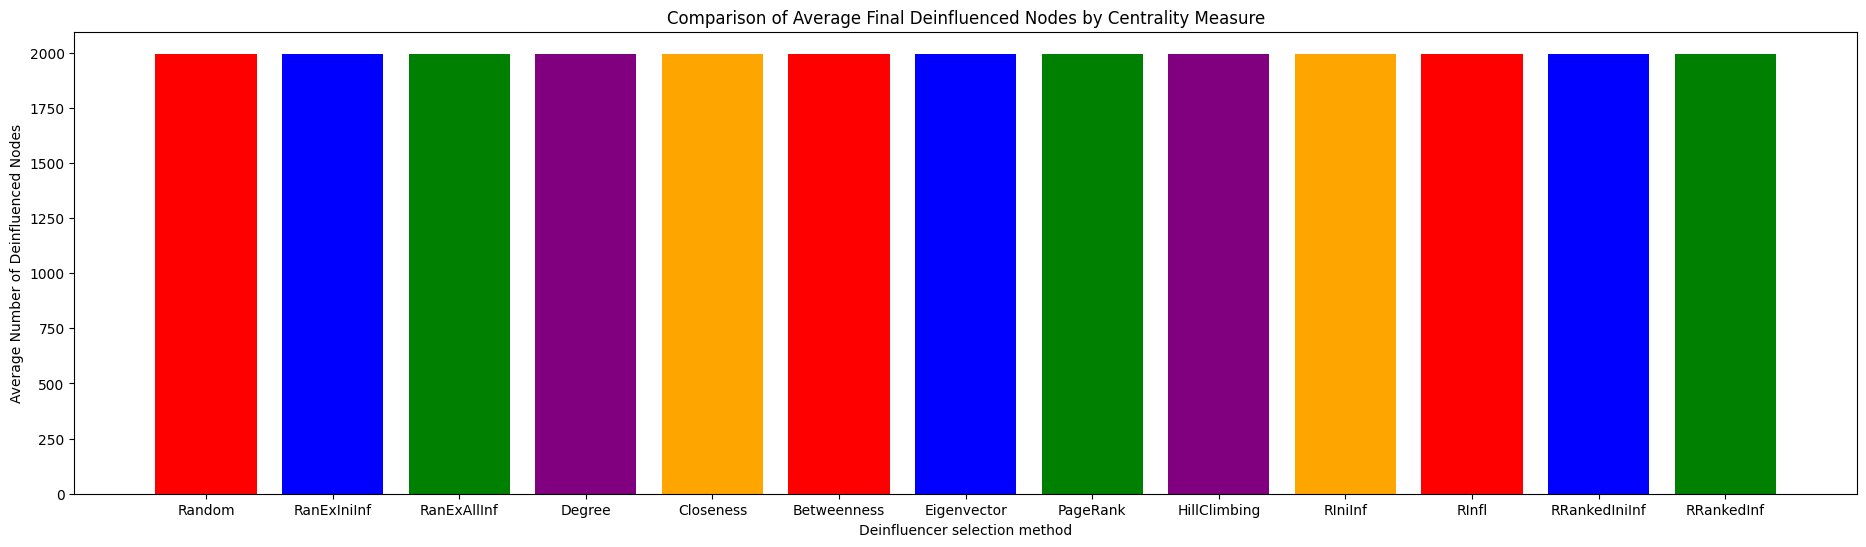

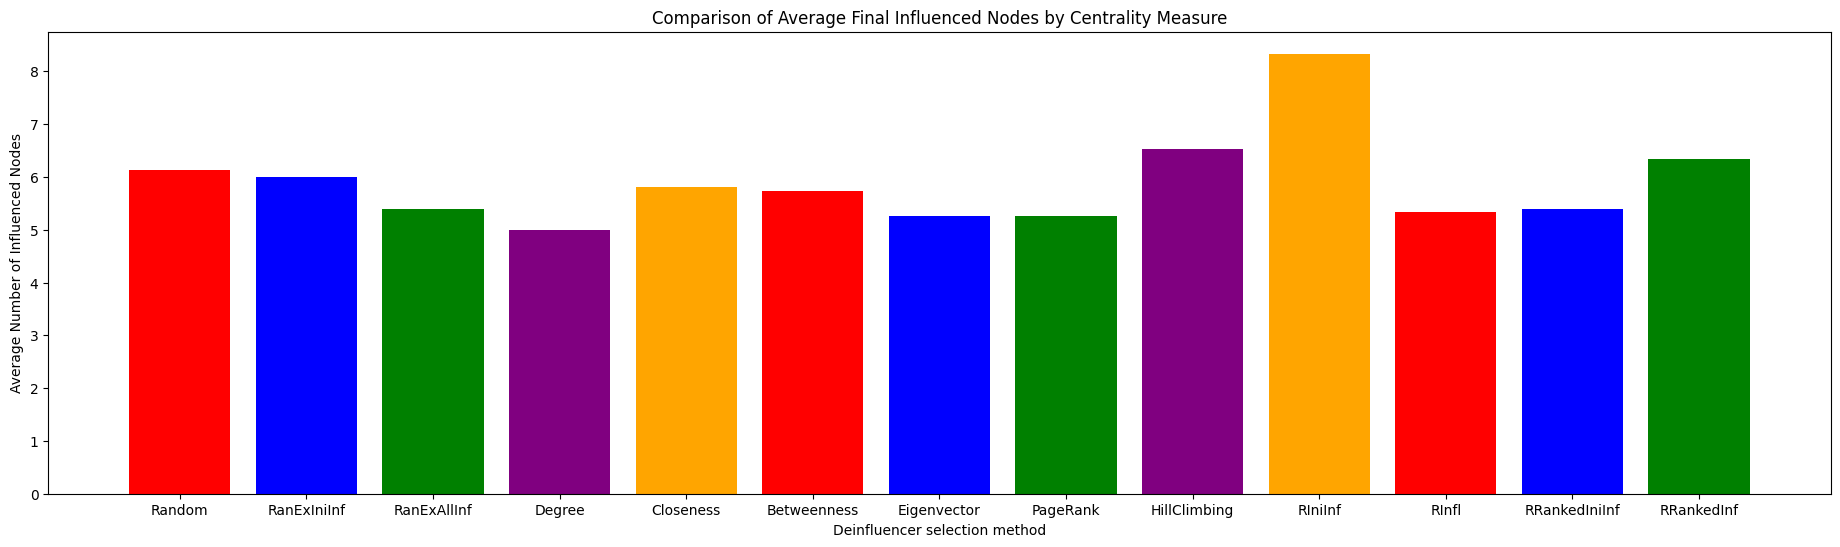

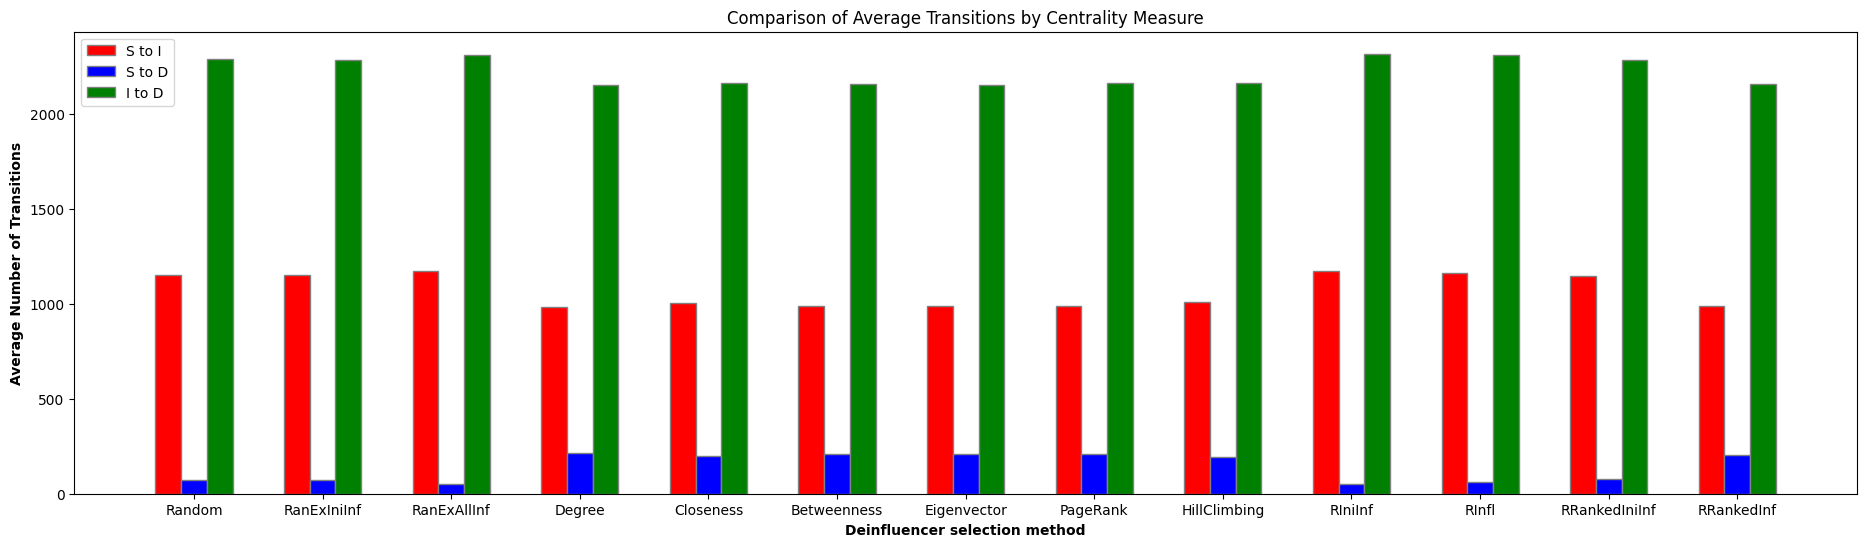

In [33]:
def average_results(k, model, deinfluencers_methods, num_runs, steps):
    cumulative_results = {method: (0, 0, {'I->S': 0, 'D->S': 0, 'D->I': 0}) for method in deinfluencers_methods.keys()}
    
    for _ in range(k):
        results = {
            method: count_deinfluenced(model_fixed_influencers, deinfluencers, num_runs)
            for method, deinfluencers in deinfluencers_methods.items()
        }
        
        for method, result in results.items():
            cumulative_results[method] = (
                cumulative_results[method][0] + result[0],
                cumulative_results[method][1] + result[1],
                {key: cumulative_results[method][2][key] + result[2][key] for key in result[2]}
            )
    
    average_results = {
        method: (
            cumulative_results[method][0] / k,
            cumulative_results[method][1] / k,
            {key: cumulative_results[method][2][key] / k for key in cumulative_results[method][2]}
        )
    for method in cumulative_results}
    
    return average_results

# Define the deinfluencer methods
deinfluencers_methods = {
    'Random': random_deinfluencers,
    'RdExIniInf': random_besides_ini_influencers,
    'RdExAllInf': random_besides_all_influencers,
    'Degree': degree_centrality_ranking,
    'Closeness': closeness_centrality_ranking,
    'Betweenness': betweenness_centrality_ranking,
    'Eigenvector': eigenvector_centrality_ranking,
    'PageRank': pagerank_centrality_ranking,
    'HillClimbing': hill_climbing_deinfluencers,
    'RdIniInf': deinfluencers_from_influencers_ini,
    'RdAllInf': deinfluencers_from_influencers,
    'RRkIniInf': ranked_deinfluencers_from_influencers_ini,
    'RRkAllInf': ranked_deinfluencers_from_influencers
}

# Run the comparison k times and get average results
k = 5
num_runs = 3
steps = 3

average_results = average_results(k, model, deinfluencers_methods, num_runs, steps)

results_d = {key: val[0] for key, val in average_results.items()}
results_i = {key: val[1] for key, val in average_results.items()}
results_w = {key: val[2] for key, val in average_results.items()}

# Print the results
print("Results for deinfluenced nodes:")
for method, count in results_d.items():
    print(f"{method}: {count:.2f} nodes deinfluenced on average")

print("\nResults for influenced nodes:")
for method, count in results_i.items():
    print(f"{method}: {count:.2f} nodes influenced on average")

print("\nResults for transitions:")
for method, counts in results_w.items():
    print(f"{method}: I->S: {counts['I->S']:.2f}, D->S: {counts['D->S']:.2f}, D->I: {counts['D->I']:.2f}")

# Plot the results
plt.figure(figsize=(23, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()

plt.figure(figsize=(23, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()

# Unpack the values
values1 = [val['I->S'] for val in results_w.values()]
values2 = [val['D->S'] for val in results_w.values()]
values3 = [val['D->I'] for val in results_w.values()]

# Create a new figure
plt.figure(figsize=(23, 6))  # Increase the figure size

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(values1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, values1, color='red', width=bar_width, edgecolor='grey', label='S to I')
plt.bar(r2, values2, color='blue', width=bar_width, edgecolor='grey', label='S to D')
plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='I to D')

# Add labels
plt.xlabel('Deinfluencer selection method', fontweight='bold')
plt.ylabel('Average Number of Transitions', fontweight='bold')
plt.title('Comparison of Average Transitions by Centrality Measure')

# Add the xticks
plt.xticks([r + bar_width for r in range(len(values1))], results_w.keys())

# Create legend
plt.legend()

# Show the plot
plt.show()